In [405]:
# Common imports

import pandas as pd
import numpy as np
import os 
import sys
import math
import utm
import time

# import json
# import geopandas as gpd
# import fiona
from geopy import distance

from numba import jit

# from shapely.geometry import shape, mapping

# from PIL import Image
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
from multiprocessing import Pool
import scipy.stats as st

#import required libraries
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.plotting import ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3

from bokeh.layouts import gridplot

import matplotlib.pyplot as plt

import pickle

from get_station_data import get_daily_runoff
from radar_station_coords import radar_sites

from minisom import MiniSom
from pyproj import Proj
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

output_notebook()


Loading BokehJS ...

In [386]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
RADAR_IMG_DIR = os.path.join(PROJECT_DIR, 'sorted_radar_images')
CROPPED_IMG_DIR = os.path.join(PROJECT_DIR, 'data/masked_img')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'data/AD_results')

In [387]:
def find_closest_radar_stn(row):
    """ 
    Input the dict of all station distances,
    Return the location code of the nearest radar station.
    """
    radar_station_distances = row['radar_stn_distance_dict']
    min_dist = min(radar_station_distances.items(), key=lambda x: x[1])
    return min_dist[0]


def find_closest_radar_stn_distance(row):
    """ 
    Input the dict of all station distances,
    Return the location code of the nearest radar station.
    """
    radar_station_distances = row['radar_stn_distance_dict']
    min_dist = min(radar_station_distances.items(), key=lambda x: x[1])
    return min_dist[1]

def calc_distance(wsc_row, station):
    wsc_stn_coords = (wsc_row['Latitude'], wsc_row['Longitude'])
    radar_coords = radar_sites[station]['lat_lon']
    return distance.distance(radar_coords, wsc_stn_coords).km

def calculate_radar_stn_distances(row):
    distance_dict = {}
    for site in radar_sites:
        distance_dict[site] = calc_distance(row, site)
    return distance_dict

In [388]:
def initialize_wsc_station_info_dataframe():
    # import master station list
    stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')
    # filter for stations that have concurrent record with the historical radar record
    stations_df['RADAR_Overlap'] = stations_df['Year To'].astype(int) - 2007
    stations_filtered = stations_df[stations_df['RADAR_Overlap'] > 0]
    # filter for stations that are natural flow regimes
    stations_filtered = stations_filtered[stations_filtered['Regulation'] == 'N']
    stations_filtered.rename(columns={'Gross Drainage Area (km2)': 'DA'}, inplace=True)
    # filter for stations in Alberta and British Columbia
    stations_filtered = stations_filtered[(stations_filtered['Province'] == 'BC') | (stations_filtered['Province'] == 'AB')]
    
    # calculate distance to each radar station
    stations_filtered['radar_stn_distance_dict'] = stations_filtered.apply(lambda row: calculate_radar_stn_distances(row), axis=1)    
    stations_filtered['closest_radar_station'] = stations_filtered.apply(lambda row: find_closest_radar_stn(row), axis=1)
    stations_filtered['radar_distance_km'] = stations_filtered.apply(lambda row: find_closest_radar_stn_distance(row), axis=1)
    
    # radar range is a 240km radius from the station
    stations_filtered = stations_filtered[stations_filtered['radar_distance_km'] < 200]
    stn_df = stations_filtered[np.isfinite(stations_filtered['DA'].astype(float))]
    # filter for stations greater than 10 km^2 (too small for meaningful results)
    stn_df = stn_df[stn_df['DA'].astype(float) >= 10]
    # filter for stations smaller than 1000 km^2 (too large and complex)
    stn_df = stn_df[stn_df['DA'].astype(float) < 1000].sort_values('DA')
    df = stn_df[['Province', 'Station Number', 'Station Name', 'DA', 
                 'Elevation', 'Latitude', 'Longitude', 'RADAR_Overlap',
                'closest_radar_station', 'radar_stn_distance_dict', 'radar_distance_km']]
#     print('After filtering, there are {} candidate stations.'.format(len(stn_df)))
    df.reset_index(inplace=True)
    return df


In [389]:
wsc_stn_data = initialize_wsc_station_info_dataframe()

In [390]:
fpath = os.path.join(PROJECT_DIR, 'data/spatial_precip_data.p')
print(fpath)
with open(fpath, 'rb') as fp:
    spatial_data = pickle.load(fp)

/home/danbot/Documents/UBC/EOSC_510/TP/data/spatial_precip_data.p


In [391]:
orog_fp = os.path.join(PROJECT_DIR, 'data/orographic_precip_data.p')
with open(orog_fp, 'rb') as fp:
    orog_data = pickle.load(fp)

In [392]:
normed_distributions = []

precip_dist_dict = {}
orog_dict = {}
q = np.linspace(0.1,99.9, 100)
i = 0
max_site = None
max_vol = 0
orog_data_sites = [e for e in list(orog_data.keys()) if e not in ['05BL014','05BJ004', '05BL023',
                                                                  '08LE027', '05BL019', '08NL050',
                                                                 '08NK018', '08LB069', '08KB006',
                                                                  '05BG006', '05CA004', '05CC013',
                                                                  '05CC011', '05BL022', '05CE012',
                                                                 ]]

def round_down(x):
    return 

for stn in orog_data_sites:
    stn_info = wsc_stn_data[wsc_stn_data['Station Number'] == stn]
    
    orog_df = orog_data[stn]
    
#     print(orog_df.head())
    total_duration = orog_df.loc[0, 'total_duration']
    # eliminate less than ten days worth of recorded precipitation
    if total_duration > 480:
#         print('{} total duration = {}'.format(stn , total_duration))
    #     precip_vol_raw = np.percentile(orog_df['total_vol'], q)
    #     precip_rate_raw = np.percentile(orog_df['avg_precip_rate'], q)

        orog_raw = orog_df.groupby('elevation').sum()[['total_vol']]
        median_value = orog_df.groupby('elevation').median()[['total_vol']]

        min_el, max_el = orog_raw.index.min(), orog_raw.index.max()
        n_bins = int(math.ceil((max_el - min_el) / 100))
    #     print(n_bins)
        start_el = int(math.floor(min_el/10) * 10)
    #     print(min_el, max_el)
        orog_hist = orog_df.groupby(pd.cut(orog_df['elevation'], np.arange(start_el, max_el, 100))).median()
    #     print(orog_hist)
        bins = pd.qcut(orog_df['elevation'], q=10)

        even_bin_hist = orog_df.groupby(bins)[['elevation', 'total_vol', 'avg_precip_rate']].agg(['count', 'sum', 'median'])

        orog_dict[stn] = {'elevation': orog_raw.index.values,
                         'total_vol': orog_raw['total_vol'].values,
                         'median_vol': median_value['total_vol'].values,
                         'binned_precip': {'elevation': orog_hist.index.values,
                                          'median_vol': orog_hist['avg_precip_rate'].values,
                                           'total_vol': orog_hist['total_vol'].values
                                          },
                          'even_bin_precip': {'elevation': even_bin_hist.index.values,
                                              'median_vol': even_bin_hist['avg_precip_rate']['median'].values,
                                              'total_vol': even_bin_hist['total_vol']['sum'].values
                                            },
                          'total_duration': total_duration
                         }

        this_max_vol = np.max(orog_raw['total_vol'])
        if this_max_vol > max_vol:
            max_vol = this_max_vol
            max_site = stn

#     precip_dist_norm = precip_dist_raw / np.linalg.norm(precip_dist_raw)
#     if i % 10 == 0:
#         print(precip_dist_norm)
#     normed_distributions.append(precip_dist_norm)
    
#     precip_dist_dict[stn] = precip_dist_norm

In [393]:
print(max_site,  max_vol)

08NM171 3538000.0


In [394]:
# d = np.array(normed_distributions)


In [395]:
#run SOM -- this code creates/trains the SOM and calculates stats of interest

nx = 3
ny = 3

#make, initialize, and train the SOM
print(d.shape)
som = MiniSom(nx, ny, d.shape[1], sigma=.5, learning_rate=0.36) # initialization of (ny x nx) SOM
som.pca_weights_init(d)
som.train_random(d, 500) # trains the SOM with 100 iterations

qnt = som.quantization(d) #this is the pattern of the BMU of each observation (ie: has same size as data input to SOM)
bmu_patterns = som.get_weights() #this is the pattern of each BMU; size = (nx, ny, len(data[0]))
QE = som.quantization_error(d) #quantization error of map
TE = som.topographic_error(d) #topographic error of map

#calculate the BMU of each observation
bmus = []
for kk in range(len(d)):
    bmus.append(som.winner(d[kk]))
    
#inds gives the sequential coordinates of each SOM node (useful for plotting)
inds = []
for ii in range(ny):
    for jj in range(nx):
        inds.append((ii,jj))
     


NameError: name 'd' is not defined

In [396]:
# compute the frequency of each BMU
freq = np.zeros((nx,ny))
for bmu in bmus:
    freq[bmu[0]][bmu[1]]+=1
freq/=len(data)

NameError: name 'bmus' is not defined

NameError: name 'inds' is not defined

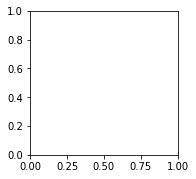

In [397]:
#visualize

plt.figure(figsize=(3*nx,3*ny))
for kk in range(nx*ny):   
    plt.subplot(ny,nx,kk+1)
    indx = inds[kk][1]
    indy = inds[kk][0]
#     plt.imshow(np.reshape(bmu_patterns[indx][indy],(faceH,faceW)).T,cmap='gray')
    plt.plot(np.reshape(bmu_patterns[indx][indy], (100)).T)
    plt.title(str(inds[kk]) + '\n Freq = ' + str(freq[indx][indy]*100)[:4] + '%')
    
plt.tight_layout()

KeyError: '08NE077'

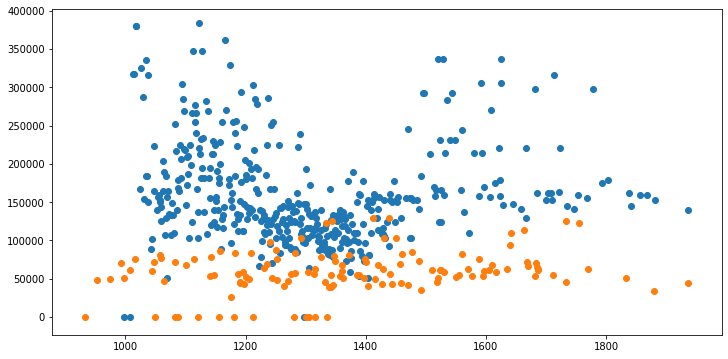

In [398]:
fig, ax = plt.subplots(figsize=(12, 6))
for stn in orog_data_sites:
    els = orog_dict[stn]['elevation']
    precip = orog_dict[stn]['median_vol']
    ax.scatter(els, precip)
plt.title('asdf')
ax.set_ylabel('Mean Precipitaton (mm)')
ax.set_xlabel('Elevation (masl)')
plt.show()

In [ ]:
for i in range(1, 43):
    if 85 % i == 0:
        print(i)

In [399]:
def create_orography_figure(stn, data, n_days):
    els = [(e.left + e.right)/2. for e in this_data['elevation']]
    precip = this_data['median_vol']
    if len(els) > 2:
        try:
            slope, intercept, r_value, p, _ = st.linregress(els, precip)
        except ValueError as err:
            print(err)
            print(els, precip)
            
        if np.any(np.isnan((slope, intercept, r_value))):
            return None, None, None
        
        if sum(precip) == 0:
            return None, None, None
            
        x = np.linspace(np.min(els), np.max(els), 100)
        y = [e * slope + intercept for e in x]
            
        fig = figure(title='{} {:.2f}: {:.2f} ({} days)'.format(stn, slope, r_value, n_days))
        fig.circle(els, precip, color='blue')
        fig.line(x, y, color='red')
        fig.xaxis.major_label_orientation = math.pi / 2
        fig.title.text_font_size = '8pt'
        return fig, slope, r_value
    return None, None, None


In [400]:
from bokeh.layouts import grid, row, column
from bokeh.plotting import figure
from bokeh.io import show

all_figs, all_m, all_r, good_stns, median_basin_els = [], [], [], [], []
lats, lons, DAs = [], [], []
for stn in orog_dict:
    stn_data = wsc_stn_data[wsc_stn_data['Station Number'] == stn]
    stn_da = stn_data['DA'].values[0]
    stn_lat, stn_lon = stn_data['Latitude'].values[0], stn_data['Longitude'].values[0]
    
    median_el = np.median(orog_dict[stn]['elevation'])
    this_data = orog_dict[stn]['even_bin_precip']
    n_days = int(orog_dict[stn]['total_duration'] / 24)
    this_fig, this_slope, this_r = create_orography_figure(stn, this_data, n_days)
    if this_fig is not None:
        all_figs.append(this_fig)
        all_m.append(this_slope)
        all_r.append(this_r)
        good_stns.append(stn)
        median_basin_els.append(median_el)
        lats.append(stn_lat)
        lons.append(stn_lon)
        DAs.append(stn_da)
            
n_cols = 6
n_rows = int(np.ceil(len(all_figs) / n_cols)) 


In [401]:
oro_results_df = pd.DataFrame()
oro_results_df['stn'] = good_stns
oro_results_df['slope'] = all_m
oro_results_df['r_value'] = all_r
oro_results_df['median_basin_el'] = median_basin_els
oro_results_df['Latitude'] = lats
oro_results_df['Longitude'] = lons
oro_results_df['DA'] = DAs
print(oro_results_df)

        stn     slope   r_value  median_basin_el  Latitude  Longitude     DA
0   05DB002 -0.023011 -0.318507           1279.5  52.27386 -114.92918  844.0
1   08NN019  0.021302  0.522061           1348.0  49.56537 -119.05196  145.0
2   08LF099  0.000363  0.183491           1433.0  50.83575 -121.23995   50.5
3   05CG006  0.358750  0.562594            986.0  51.39080 -112.20187  118.0
4   08MH029 -0.018704 -0.595434             88.5  49.00249 -122.23230  144.0
5   08NL071 -0.000238 -0.282653           1550.0  49.46568 -120.97891  253.0
6   08NN023  0.002534  0.228047           1447.0  49.58914 -118.31175  221.0
7   08LG048  0.011771  0.937725           1421.5  49.85422 -120.90846  316.0
8   05BL013  0.016191  0.695349           1468.5  50.77113 -114.27874  507.0
9   08NH130 -0.002351 -0.512715           2026.0  50.08200 -116.78486  585.0
10  08MH147 -0.000963 -0.723303           1299.0  49.55619 -122.32307  290.0
11  05CD007 -0.333887 -0.772074            863.5  52.40747 -113.19576  511.0

In [562]:
g = []
for i in range(0, len(all_figs), n_cols):
    print(i)
    this_plot = all_figs[i]
    if i % n_cols == 0:
        this_plot.yaxis.axis_label = 'Median Precip [mm]'
    if i >= 36:
        this_plot.xaxis.axis_label = 'Elevation [masl]'
    g += [all_figs[i:i+n_cols]]
    
grid = gridplot(g, plot_width=200, plot_height=175)

show(grid)

0
6
12
18
24
30
36


In [ ]:
#now, loop through and create a range of sizes of SOMs and compare TE and QE 

def calculate_QE_TE(s, lr, d):
    ny_array = [2,3,3,4,4,5,5,6,6,7,7]
    nx_array = [2,2,3,3,4,4,5,5,6,6,7]

    QE = []
    TE = []
    for kk in range(len(ny_array)):
        nx = nx_array[kk]
        ny = ny_array[kk]

        #make, initialize, and train the SOM
        data = d
        som = MiniSom(nx, ny, 100, sigma=s, learning_rate=lr) # initialization of SOM
        som.pca_weights_init(d)
        som.train_random(d, 100) # trains the SOM with N iterations

        qnt = som.quantization(d) #this is the pattern of the BMU of each observation (ie: has same size as data input to SOM)
        bmu_patterns = som.get_weights() #this is the pattern of each BMU; size = (nx, ny, len(data[0]))
        QE.append(som.quantization_error(d)) #quantization error of map
        TE.append(som.topographic_error(d)) #topographic error of map
    
    return QE, TE

In [ ]:
n_dims = 20

ss = [0.5, 0.75, 1.5]
lr = np.linspace(0.12, .5, n_dims)

combos = [(s, l, d) for s in ss for l in lr]

In [824]:

QEs, TEs = [], []
i = 0
t0 = time.time()
xs = []
for c in combos:
    qe, te = calculate_QE_TE(c[0], c[1], d)
    QEs.append(qe)
    TEs.append(te)
    xs.append([i + i * len(qe) for n in range(len(qe))])
    t1 = time.time()
    if i % 10 == 0:
        print('{} of {} in {:.2f}s'.format(i, len(combos), t1-t0))
    i += 1

0 of 60 in 0.34s
10 of 60 in 3.14s
20 of 60 in 5.96s
30 of 60 in 9.13s
40 of 60 in 12.12s
50 of 60 in 15.23s


i here =  11
11 11


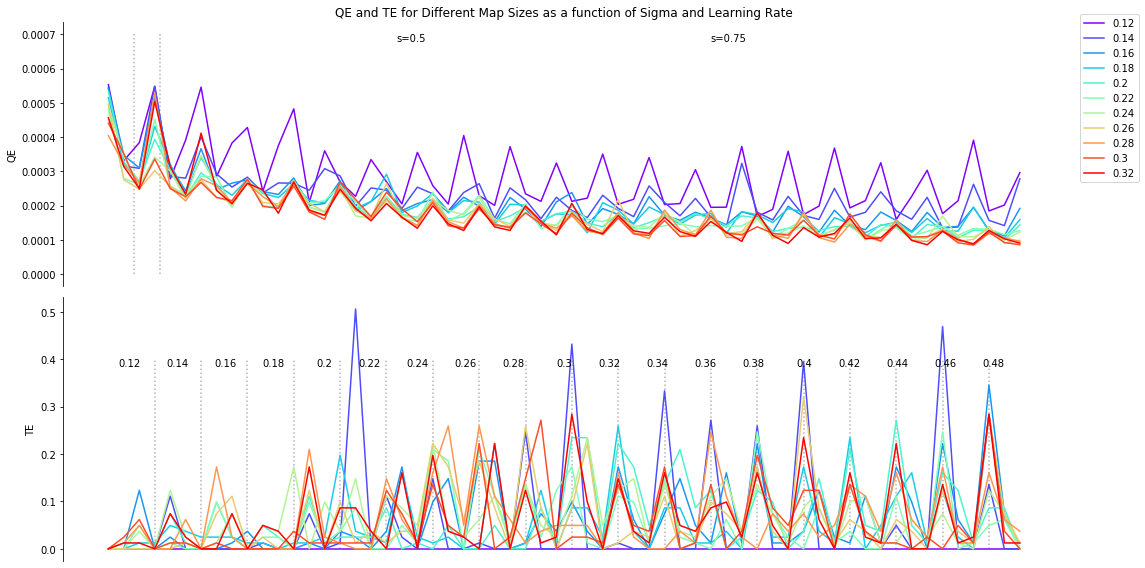

In [826]:
#visualize QE and TE (two different y axes)

QEs1 = np.array(QEs).T
TEs1 = np.array(TEs).T
xs1 = np.array(xs).T

colors = cm.rainbow(np.linspace(0, 1, len(QEs1)))


fig, ax = plt.subplots(2,1,figsize=(16, 8))
#QE
color = 'tab:red'
ax[0].set_ylabel('QE')

for i in range(1, 3):
    ax[0].vlines(i * len(lr), 0, 0.0007, linestyles='dotted', alpha=0.3)
#     print(s[(i-1)*n_dims])
    ax[0].annotate('s='+str(round(ss[i-1], 2)),
            xy=(-2, 0.0007), xycoords='data',
            xytext=(320*i, 1), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top')


i = 0
for qe in QEs1:
    ax[0].plot(xs1[i], qe, color=colors[i], label = round(lr[i],2))
    i += 1

print('i here = ', i)
# ax[0].tick_params(axis='y',labelcolor=color)
#TE
color = 'tab:blue'
ax[1].set_ylabel('TE')
color = 'tab:blue'
ax[1].set_ylabel('TE')
i = 0
for te in TEs1:
    ax[1].plot(te, color=colors[i],  label = round(lr[i],2))
    i += 1

i = 0
n = 0
print(len(TEs1), len(QEs1))
    
for i in range(1, len(lr)):
    ax[1].vlines(i * len(ss), 0, 0.4, linestyles='dotted', alpha=0.3)
#     print(s[(i-1)*n_dims])
    ax[1].annotate(str(round(lr[i-1], 2)),
            xy=(-1.05, 0.4), xycoords='data',
            xytext=(48*i, 1), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top')

    
ax[0].legend()
ax[0].legend(bbox_to_anchor=(1.01, 1.05))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].axes.get_xaxis().set_visible(False)
ax[1].axes.get_xaxis().set_visible(False)
ax[0].set_title('QE and TE for Different Map Sizes as a function of Sigma and Learning Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [820]:
combos = [(s, l, d) for l in lr for s in ss]

In [821]:
QEs, TEs = [], []
i = 0
t0 = time.time()
for c in combos:
    qe, te = calculate_QE_TE(c[0], c[1], d)
    QEs.append(qe)
    TEs.append(te)
    t1 = time.time()
    if i % 10 == 0:
        print('{} of {} in {:.2f}s'.format(i, len(combos), t1-t0))
    i += 1

0 of 60 in 0.29s
10 of 60 in 3.63s
20 of 60 in 6.51s
30 of 60 in 9.90s
40 of 60 in 13.22s
50 of 60 in 16.34s


(11, 60)
(11, 60)


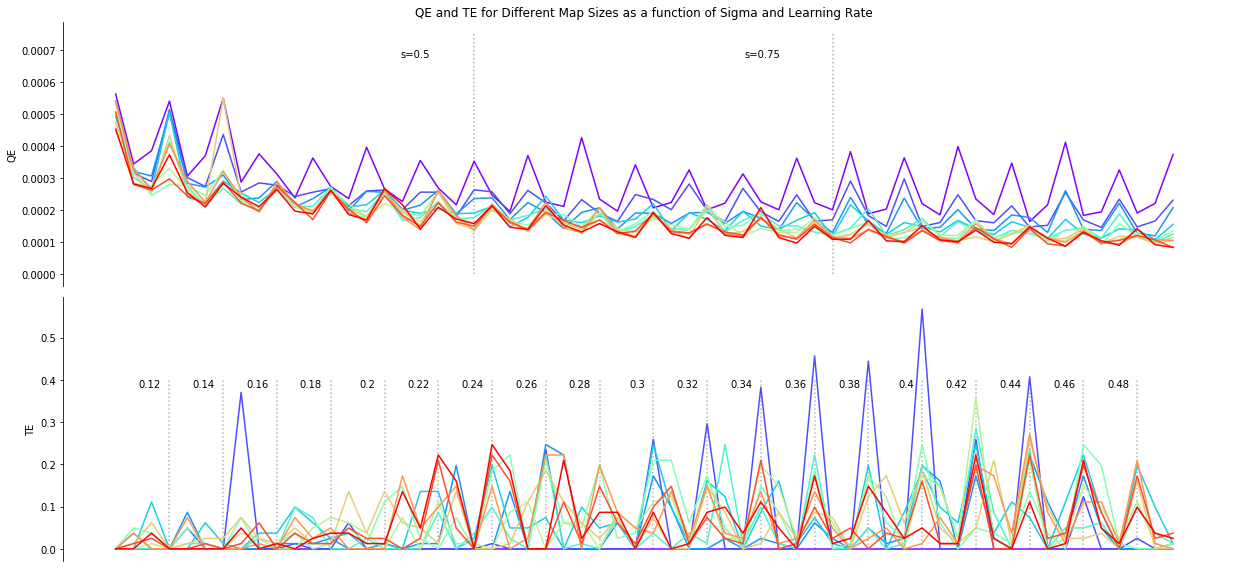

In [806]:
#visualize QE and TE (two different y axes)
import matplotlib.cm as cm

fig, ax = plt.subplots(2,1,figsize=(18, 8))
#QE
color = 'tab:red'
ax[0].set_ylabel('QE')

QEs1 = np.array(QEs).T
TEs1 = np.array(TEs).T
print(np.shape(QEs1))

for i in range(1, 3):
    ax[0].vlines(i * 20, 0, 0.00075, linestyles='dotted', alpha=0.3)
#     print(s[(i-1)*n_dims])
    ax[0].annotate('s=' + str(round(ss[i-1], 2)),
            xy=(-2, 0.0007), xycoords='data',
            xytext=(350*i, 1), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top')

i = 0
for qe in QEs1:
    ax[0].plot(qe, color=colors[i])
    i += 1
# ax[0].tick_params(axis='y',labelcolor=color)
#TE
color = 'tab:blue'
ax[1].set_ylabel('TE')
i = 0
for te in TEs1:
    ax[1].plot(te,color=colors[i])
    i += 1

print(np.shape(TEs1))
i = 0
n = 0    
for i in range(1, 20):
    top_pos = 0.4
    ax[1].vlines(i * 3, 0, top_pos, linestyles='dotted', alpha=0.3)
#     print(s[(i-1)*n_dims])
    ax[1].annotate(str(round(lr[i-1], 2)),
            xy=(-0.5, top_pos), xycoords='data',
            xytext=(53.8*i, 1), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].axes.get_xaxis().set_visible(False)
ax[1].axes.get_xaxis().set_visible(False)
ax[0].set_title('QE and TE for Different Map Sizes as a function of Sigma and Learning Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Derive Hypsometric curves for all DAs

In [16]:
dem_save_path = os.path.join(PROJECT_DIR, 'data/dem_data')

In [27]:
all_pickles = [e.split('.')[0] for e in os.listdir(dem_save_path)]
print(all_pickles)
# print(ddd)

['08NE110', '08MH155', '08KA009', '08MC045', '08KB006', '05CE018', '05DB005', '08JE004', '05CA011', '05AA027', '05AB013', '08LE027', '08NB014', '05BJ004', '08LB024', '08NM173', '08NK022', '08HB086', '08NE087', '05AB029', '08LG048', '05CD007', '05BM014', '05BL014', '08MG001', '08NJ026', '05CE010', '05CC013', '08MH147', '08MH029', '08ND012', '05FA014', '08NM174', '08NK018', '05CA012', '08NJ061', '08KA001', '05AA909', '05BL013', '08GA072', '08NM142', '05BH014', '05BG006', '05CG004', '08MH141', '08GA075', '07EE009', '08HA070', '08NJ160', '05CA004', '05FC007', '08GA077', '05AB040', '08NJ168', '08NN015', '08NL050', '08NH130', '08NH005', '08NN023', '08KE024', '08NN019', '08HB089', '05BL023', '05DB002', '05AC030', '08GA079', '05BM018', '08LC040', '08LG016', '08NE114', '05CG006', '08NE039', '08MH076', '05BK001', '08LF094', '05AD035', '08HA003', '08NE077', '08MH006', '05BL019', '05CA002']


In [77]:
spatial_data_sites = list(spatial_data.keys())
# print(len(spatial_data_sites))

# common_sites = [e for e in all_pickles if e in spatial_data_sites]

common_sites = np.intersect1d(list(spatial_data.keys()), all_pickles)
print(common_sites)
print(len(common_sites))

['05AA027' '05AB013' '05AB029' '05AB040' '05AC030' '05AD035' '05BH014'
 '05BK001' '05BL013' '05BL014' '05BM014' '05BM018' '05CA002' '05CA011'
 '05CA012' '05CC013' '05CD007' '05CE010' '05CE018' '05CG004' '05CG006'
 '05DB002' '05DB005' '05FA014' '05FC007' '07EE009' '08GA075' '08GA077'
 '08GA079' '08HA003' '08HA070' '08JE004' '08KA001' '08KE024' '08LB024'
 '08LC040' '08LF094' '08LG016' '08LG048' '08MC045' '08MG001' '08MH029'
 '08MH076' '08MH141' '08MH147' '08MH155' '08ND012' '08NE039' '08NE077'
 '08NE087' '08NE110' '08NE114' '08NH005' '08NH130' '08NJ026' '08NJ061'
 '08NJ160' '08NK022' '08NM142' '08NM174' '08NN015' '08NN019' '08NN023']
63


In [96]:
hypsos = []
hypso_dict = {}
for stn in all_pickles:
    
    dem_data = pickle.load( open(os.path.join(dem_save_path, stn + '.p'), "rb" ) )
    
    non_nan_data = dem_data[np.where(~np.isnan(dem_data))].flatten()
    non_nan_data = non_nan_data - np.min(non_nan_data)
    
#     print('Station {} ({} km^2) count: {}'.format(stn, stn_info['DA'].values[0], len(non_nan_data)))

    hypso_dist_raw = np.percentile(non_nan_data, q)
    hypso_dist_norm = hypso_dist_raw / np.linalg.norm(hypso_dist_raw)
#     if i % 10 == 0:
#         print(precip_dist_norm)
    hypsos.append(hypso_dist_norm)
    hypso_dict[stn] = hypso_dist_norm
    

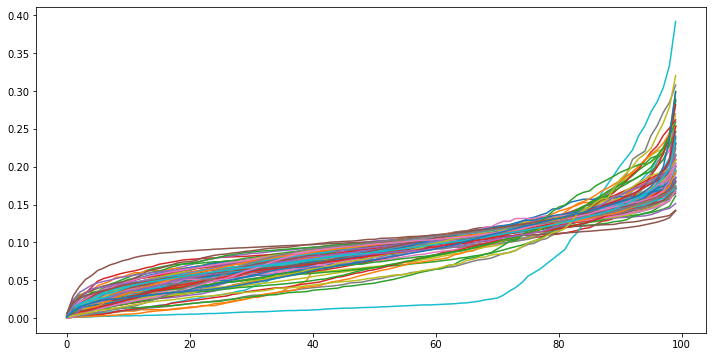

In [97]:
d = np.array(hypsos)

fig, ax = plt.subplots(figsize=(12, 6))

p = ax.plot(d.T)
plt.show(p)

In [98]:
nx = 3
ny = 3

#make, initialize, and train the SOM
print(d.shape)
som = MiniSom(nx, ny, d.shape[1], sigma=.5, learning_rate=0.36) # initialization of (ny x nx) SOM
som.pca_weights_init(d)
som.train_random(d, 500) # trains the SOM with 100 iterations

qnt = som.quantization(d) #this is the pattern of the BMU of each observation (ie: has same size as data input to SOM)
bmu_patterns = som.get_weights() #this is the pattern of each BMU; size = (nx, ny, len(data[0]))
QE = som.quantization_error(d) #quantization error of map
TE = som.topographic_error(d) #topographic error of map

#calculate the BMU of each observation
bmus = []
for kk in range(len(d)):
    bmus.append(som.winner(d[kk]))
    
#inds gives the sequential coordinates of each SOM node (useful for plotting)
inds = []
for ii in range(ny):
    for jj in range(nx):
        inds.append((ii,jj))
     


(81, 100)


In [99]:
freq = np.zeros((nx,ny))
for bmu in bmus:
    freq[bmu[0]][bmu[1]]+=1
freq/=len(data)

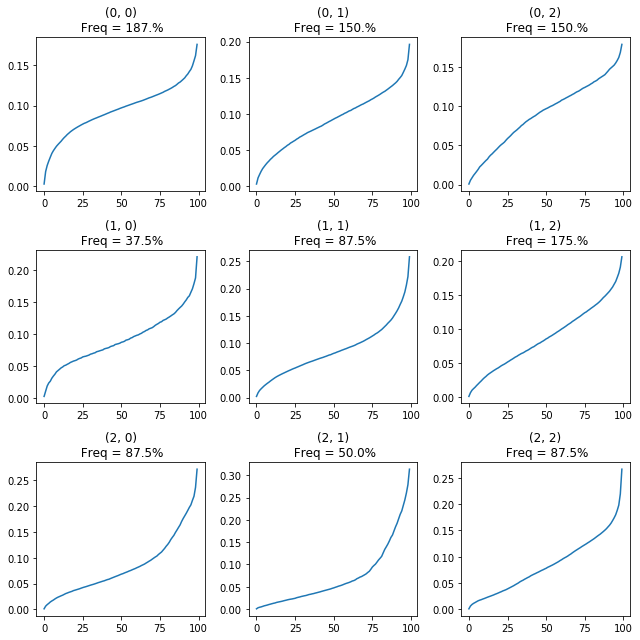

In [100]:
plt.figure(figsize=(3*nx,3*ny))
for kk in range(nx*ny):   
    plt.subplot(ny,nx,kk+1)
    indx = inds[kk][1]
    indy = inds[kk][0]
#     plt.imshow(np.reshape(bmu_patterns[indx][indy],(faceH,faceW)).T,cmap='gray')
    plt.plot(np.reshape(bmu_patterns[indx][indy], (100)).T)
    plt.title(str(inds[kk]) + '\n Freq = ' + str(freq[indx][indy]*100)[:4] + '%')
    
plt.tight_layout()

In [106]:
import scipy.stats as st

common_sites = 

for site in list(spatial_data.keys()):
    if site in all_pickles:
        precip = precip_dist_dict[site]
        hypso = hypso_dict[site]
    
        fit = np.polyfit(precip, hypso, 1)
        slope, intercept, r_value, p_value, std_err = st.linregress(precip, hypso)
        
        print(site, fit, r_value)
    
    

08ND012 [ 1.33736443 -0.0367212 ] 0.9685447739945533
05DB002 [ 1.14905548 -0.01790791] 0.9551341852844301
05CA002 [ 1.28114428 -0.03309229] 0.9485424724683597
05CC013 [0.77739892 0.02484287] 0.9715561214171603
05BM014 [0.47465535 0.05841406] 0.9356368446226745
05BL014 [ 1.17304392 -0.02042603] 0.9837956350387765
08NH130 [0.75226919 0.02666738] 0.9841443271903632
05CD007 [9.90755791e-01 4.67981328e-04] 0.9681669151369675
05BL013 [ 2.38534332 -0.15071947] 0.9229939375217662
05CA012 [ 1.30726903 -0.03574604] 0.9512055941668878
08NH005 [0.81186961 0.01944086] 0.928768586956148
08JE004 [ 1.46519575 -0.05167069] 0.9740586094615312
08KA001 [0.46640373 0.05821682] 0.8774653434560116
08MG001 [0.57667896 0.04863441] 0.931418303972157
05AC030 [0.58122914 0.04673721] 0.9565497441587023
08NE039 [ 1.04924163 -0.00555966] 0.9881732600774307
08LG048 [ 1.13919933 -0.01604568] 0.9490699450413037
07EE009 [ 1.08609264 -0.01027877] 0.9739272886675945
08NE110 [0.64560645 0.03835639] 0.9313289517905725
08MH1

In [369]:
oro_results_df.head()

,stn,slope,r_value,median_basin_el,Latitude,Longitude,DA
0,05DB002,-0.023011,-0.318507,1279.5,52.27386,-114.92918,844.0
1,08NN019,0.021302,0.522061,1348.0,49.56537,-119.05196,145.0
2,08LF099,0.000363,0.183491,1433.0,50.83575,-121.23995,50.5
3,05CG006,0.358750,0.562594,986.0,51.39080,-112.20187,118.0
4,08MH029,-0.018704,-0.595434,88.5,49.00249,-122.23230,144.0


In [516]:
d1 = oro_results_df['slope'].values
d2 = oro_results_df['median_basin_el'].values
d3 = oro_results_df['DA'].values
lats = oro_results_df['Latitude']
longs = oro_results_df['Longitude']

pair1 = np.array([e for e in zip(d2, d1)])
pair2 = np.array([e for e in zip(d1, d3)])
pair3 = np.array([e for e in zip(d2, d3)])
coords = np.array([e for e in zip(longs, lats)])

In [517]:
colors = np.array([x for x in ('#00f', '#0f0', '#f00', '#0ff', '#f0f', '#ff0')])
colors = np.hstack([colors] * 20)

In [534]:
#now cluste4
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  affinity='euclidean', 
                                  linkage='ward')
data = pair1

cn = cluster.fit_predict(data)

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(pair1)[1]))
# cluster_pattern = np.empty((n_clusters,np.shape(pair1)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(cn==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)

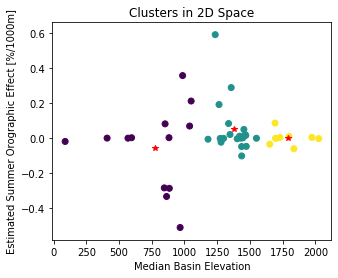

In [543]:
#visualize clusters in PC-space
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.scatter(data[:,0],data[:,1],c=cn)
ax.plot(cluster_pattern[:,0], cluster_pattern[:,1], 'r*')
# plt.scatter(cluster_pattern_PC[:,0],cluster_pattern_PC[:,1],marker='*',c='k',s=100)
ax.set_ylabel('Estimated Summer Orographic Effect [%/1000m]')
ax.set_xlabel('Median Basin Elevation')
ax.set_title('Clusters in 2D Space')

plt.show()

In [552]:
def get_polygon(stn):
    gdb_path = os.path.join(DB_DIR, 'WSC_Basins.gdb.zip')
    data = gpd.read_file(gdb_path, driver='FileGDB', layer='EC_{}_1'.format(stn))
    return data

def get_basin_geometry(test_stn):
    basin_geom = get_polygon(test_stn)
    # reproject to EPSG: 3395 (mercator) for plotting
    # or to coincide with radar image coordinates use
    # original WSC basin polygon is EPSG: 4269 (NAD83)
    # WGS 84 is EPSG: 4326
    basin_bbox = basin_geom.bounds
    return basin_geom

In [528]:
from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import Viridis4
from bokeh.transform import linear_cmap
import geopandas as gpd

output_notebook()

tile_provider = get_provider(Vendors.CARTODBPOSITRON)

minx, maxx, miny, maxy = np.min(longs), np.max(longs), np.min(lats), np.max(lats)
print(minx, maxx, miny, maxy)

print(utm.from_latlon(miny, minx))
minx, miny = utm.from_latlon(miny, minx)[:2]
maxx, maxy = utm.from_latlon(maxy, maxx)[:2]


Loading BokehJS ...

-124.96943999999999 -112.20187 48.576229999999995 54.61081
(354735.62223151233, 5382221.412700412, 10, 'U')


In [529]:
# format WSC station data points into a geodataframe
all_stations = oro_results_df['stn'].values


geo_df = oro_results_df[['stn', 'Latitude', 'Longitude']]
# geo_df.crs = geo_df.'EPSG:4326'
wsc_sites_geo = gpd.GeoDataFrame(geo_df, geometry=gpd.points_from_xy(geo_df['Longitude'], geo_df['Latitude']),
                                crs='EPSG:4326')
# Convert to Mercator for Plotting
wsc_sites_geo = wsc_sites_geo.to_crs("EPSG:3857")

# Get x and y coordinates
wsc_sites_geo['x'] = [geometry.x for geometry in wsc_sites_geo['geometry']]
wsc_sites_geo['y'] = [geometry.y for geometry in wsc_sites_geo['geometry']]
wsc_sites_geo['cn'] = cn
wsc_df = wsc_sites_geo.drop('geometry', axis = 1).copy()
sitesource = ColumnDataSource(wsc_df)

l_box, r_box = wsc_df['x'].min(), wsc_df['x'].max()
t_box, b_box = wsc_df['y'].max(), wsc_df['y'].min()

In [567]:
# tile_provider = get_provider(Vendors.CARTODBPOSITRON)
tile_provider = get_provider(Vendors.STAMEN_TERRAIN_RETINA)

#Use the field name of the column source
# mapper = linear_cmap(field_name='cn', palette=Viridis4[::-1], low=min(cn), high=max(cn))
# print(bbox)
# range bounds supplied in web mercator coordinates
p = figure(x_range=(l_box*1.0001, 1.0001*r_box), y_range=(0.98*b_box, 1.01*t_box),
           x_axis_type="mercator", y_axis_type="mercator",
          width=800, height=400,
          title='Agglomerative Clustering of Orographic Slope and Median Basin Elevation')

p.add_tile(tile_provider)
i = 0
for c_class in list(set(cn)):
    
    d = wsc_df[wsc_df['cn'] == c_class]
    t = 'Median el: {:d} Oro. slope: {:.2f}'.format(int(cluster_pattern[i, 0]), cluster_pattern[i, 1])
    
    p.circle(d['x'], d['y'], color=Viridis4[i], 
             size=10, alpha=1, legend_label=t)

    i += 1

    
    
show(p)

In [ ]:
basin_geodf = gpd.GeoDataFrame(basin_geom,
                                crs='EPSG:4326')
# convert to Mercator for plotting
basin_geo = basin_geodf.to_crs("EPSG:3857")

# Get x and y coordinates
basin_polygon = list(basin_geo.iloc[0].geometry[0].exterior.coords)

basin_df = pd.DataFrame()
basin_df['x'] = [e[0] for e in basin_polygon]
basin_df['y'] = [e[1] for e in basin_polygon]

basin_sitesource = ColumnDataSource(basin_df)

l_box, r_box = basin_df['x'].min(), basin_df['x'].max()
b_box, t_box = basin_df['y'].min(), basin_df['y'].max()

In [ ]:
i = 0
for stn in all_stations[:1]:
    i += 1
    t0 = time.time()
    basin_geom = get_basin_geometry(stn)
    basin_geodf = gpd.GeoDataFrame(basin_geom,
                                crs='EPSG:4326')
    # convert to Mercator for plotting
    basin_geo = basin_geodf.to_crs("EPSG:3857")

    # Get x and y coordinates
    basin_polygon = list(basin_geo.iloc[0].geometry[0].exterior.coords)

    basin_df = pd.DataFrame()
    basin_df['x'] = [e[0] for e in basin_polygon]
    basin_df['y'] = [e[1] for e in basin_polygon]

    basin_sitesource = ColumnDataSource(basin_df)
    
    #     l_box, r_box = basin_df['x'].min(), basin_df['x'].max()
#     b_box, t_box = basin_df['y'].min(), basin_df['y'].max()
    
    p.line('x', 'y', source=basin_sitesource, color='blue', 
     legend_label='Catchment',
      line_dash='dashed')
    t1 = time.time()
    print('{}/{} {} catchment retrieved and plotted in {:.2f}s'.format(i, len(all_stations), stn, t1-t0))